In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
def VFC(f,K):
    def cropTo(img, toShape):
        fromShape = np.array(img.shape)
        toShape = np.array(toShape)

        cropVal = ((fromShape-toShape)/2).astype(np.int8)
        xCrop,yCrop,zCrop = cropVal[0], cropVal[1], cropVal[2]
        img_crop = img[xCrop:-xCrop,yCrop:-yCrop,zCrop:-zCrop]

        return img_crop
    # pad
    kx,ky,kz = K.shape[0],K.shape[1], K.shape[2]
    f_pad = np.pad(f, ((kx,kx),(ky,ky),(kz,kz)), 'reflect')
    FFTsize = np.array(f_pad.shape) + kx-1

    fftf = np.fft.fftn(f_pad, FFTsize)
    Fz = np.real(np.fft.ifftn(fftf * np.fft.fftn(K[:,:,:,2], FFTsize)))

    temp = np.fft.ifftn(fftf*np.fft.fftn(K[:,:,:,0]+1j*K[:,:,:,1], FFTsize))
    Fy = np.imag(temp)
    Fx = np.real(temp)
    
    Fext = np.zeros(np.array([f.shape[0], f.shape[1],f.shape[2],3]))
    Fext[:,:,:,0]=cropTo(Fx, f.shape)
    Fext[:,:,:,1]=cropTo(Fy, f.shape)
    Fext[:,:,:,2]=cropTo(Fz, f.shape)
    
    return Fext

def VFK(r=10,a=1.5,R=np.array([1,1,1])):
    # VFK
    eps = 1e-8
    r0 = np.floor(r/R)
    xx,yy,zz = R[0]*np.arange(r0[0],-r0[0]-1,-1), R[1]*np.arange(r0[1],-r0[1]-1,-1), R[2]*np.arange(r0[2],-r0[2]-1,-1)
    XX,YY,ZZ = np.meshgrid(xx,yy,zz)
    dist = np.sqrt(XX**2+YY**2+ZZ**2)
    
    MASK=dist<r
    m=dist**(a+1)
    Kx,Ky,Kz = XX/(m+eps), YY/(m+eps), ZZ/(m+eps)
    Kx, Ky, Kz = Kx*MASK, Ky*MASK, Kz*MASK

    Kx = np.expand_dims(Kx, axis=3)
    Ky = np.expand_dims(Ky, axis=3)
    Kz = np.expand_dims(Kz, axis=3)

    K=np.concatenate((Kx,Ky,Kz), axis=3)
    return K

In [5]:
def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [3]:
def image_contour(image):

    """ Function to compute image contour """
  
  # Get x-gradient in "sx"
    sx = ndimage.sobel(image,axis=0,mode='constant')
  # Get y-gradient in "sy"
    sy = ndimage.sobel(image,axis=1,mode='constant')
  # Get z-gradient in "sz"
    sz = ndimage.sobel(image,axis=2,mode='constant')
  # Get square root of sum of squares
    sobel=np.hypot(sx,sy,sz)
    return sobel

In [ ]:
def image_processing(path):
  #load image
  img = nib.load(path)
  img_data = img.get_fdata()

  #show image
  show_slices([img_data[int(img_data.shape[0]/2), :, :], img_data[:, int(img_data.shape[1]/2), :] ,img_data[:, :, int(img_data.shape[2]/2)]])

  #image contour computation
  contour = image_contour(img_data)
  show_slices([contour[int(contour.shape[0]/2), :, :], contour[:, int(contour.shape[1]/2), :] ,contour[:, :, int(contour.shape[2]/2)]])

  return contour

(160, 192, 224, 3)

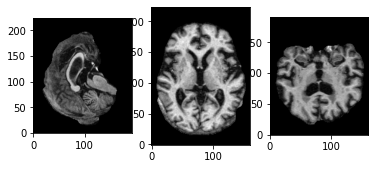

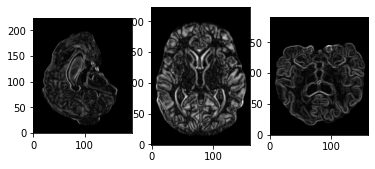

In [15]:
contour = image_processing('../data/raw/L2R_2021_Task3_test/img0001_norm.nii.gz')
Fext = VFC(contour,VFK(r=10,a=1.5,R=np.array([1,1,1])))
Fext.shape

In [16]:
Fext[0][0][8]

array([ 1.43186505e-17, -6.96120651e-15,  3.62097900e-15])

### test for implementation
<br/>
tout le truc c'est que to_tensor pour 4 dimensions ça marche pas, 
donc il faut que je regarde comment on en fait en rgb d'habitude pour les transfos
ou que j'adapte la transfo pour que ce soit réalisé sur le tensor déjà. 
cette deuxième option pourrait fonctionner parce qu'il suffirait de modifier image_contour pour qu'elle recoive un tensor en entrée et sorte un contour numpy en sortie.
<br/>
<br/>
  
mmm bon après des test, convertir en rgb ça marche pas parce que je me limiterai à 0-255 en rgb, donc je pense que la seule option c'est convertir la fonction en tensor, c'est chiant mais pourquoi pas.
<br/>
<br/>
  
en fait ça marche pas jsuis un bouffon pour sortir un tenseur faudrait réadapter tout le code, mais sinon en vrai le plus simple c'est encore de convertir en tenseur chacune des trois dimensions une à une.

In [ ]:
from process.utils import image_contour
import numpy as np

image_random=np.random.randint(0,100,(30,30,30))
contour=image_contour(image_random)